In [0]:
# import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from eeg_util_pt2 import get_pickled_data, reduce_interictal

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc


%matplotlib inline

In [0]:
# Split subjects into 2 groups, train and test
np.random.seed(3)
test_size = 4
test_ids = np.random.choice(np.arange(1,25,1), size=test_size, replace=False)
train_ids = [i for i in range(1,25,1) if i not in test_ids]
print(f"test subjects: {test_ids}")

# get data from pickle files
preictal_length = 8
# z_score calculated by individual subject
train_X, train_y = get_pickled_data(train_ids, preictal_length, clean_spectra=True, threshold=-25, z_score=True)
test_X, test_y = get_pickled_data(test_ids, preictal_length, clean_spectra=True, threshold=-25, z_score=True)

# reduce number of interictal segments
train_X, train_y = reduce_interictal(train_X, train_y, keep_size=3000, seed=17)
test_X, test_y = reduce_interictal(test_X, test_y, keep_size=500, seed=17)

# shuffle segments
np.random.seed(3)
train_order = np.random.permutation(len(train_y))
np.random.seed(3)
test_order = np.random.permutation(len(test_y))

train_X, train_y = train_X[train_order], train_y[train_order]
test_X, test_y = test_X[test_order], test_y[test_order]

for i in range(3):
    print(f"train label {i}: {(train_y==i).sum()}")
for i in range(3):
    print(f"test label {i}: {(test_y==i).sum()}")

test subjects: [23 13 18 16]
train label 0: 3000
train label 1: 300
train label 2: 2603
test label 0: 500
test label 1: 70
test label 2: 376


# KNN 3-classes

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.9s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    7.6s finished


Cross validation picked {'n_neighbors': 5, 'weights': 'distance'} as the best combination
Mean accuracy from which is 0.878
              precision    recall  f1-score   support

  interictal       0.66      0.93      0.77       500
    preictal       0.00      0.00      0.00        70
       ictal       0.82      0.53      0.64       376

    accuracy                           0.70       946
   macro avg       0.50      0.49      0.47       946
weighted avg       0.68      0.70      0.66       946



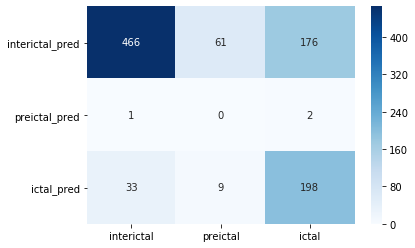

In [0]:
neighbors=[3,5,7,9]
params = {"n_neighbors": neighbors, "weights":["uniform", "distance"]}

knc_clf3 = GridSearchCV(KNC(), param_grid=params, cv=10, verbose=1, n_jobs=8)

knc_clf3.fit(train_X, train_y)

print(f"Cross validation picked {knc_clf3.best_params_} as the best combination")
print(f"Mean accuracy from which is {knc_clf3.best_score_:.3f}")


prediction = knc_clf3.predict(test_X)

confusion = confusion_matrix(test_y, prediction)
report = classification_report(test_y, prediction, labels=[0,1,2], target_names=["interictal", "preictal", "ictal"])

print(report)

sns.heatmap(
    confusion.T, 
    cmap="Blues", 
    annot=True, 
    fmt="d", 
    xticklabels=["interictal", "preictal", "ictal"], 
    yticklabels=["interictal_pred", "preictal_pred", "ictal_pred"]
)

# SVC 3-classes

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   29.2s
[Parallel(n_jobs=8)]: Done 120 out of 120 | elapsed:  1.6min finished


Cross validation picked {'C': 3, 'gamma': 0.03} as the best combination
Mean accuracy from which is 0.889
              precision    recall  f1-score   support

  interictal       0.67      0.90      0.77       500
    preictal       0.00      0.00      0.00        70
       ictal       0.77      0.54      0.64       376

    accuracy                           0.69       946
   macro avg       0.48      0.48      0.47       946
weighted avg       0.66      0.69      0.66       946



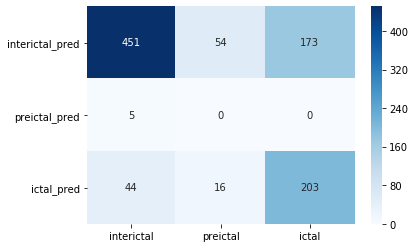

In [0]:
C_grid=[1, 3, 10]
gamma_grid=[0.01, 0.03, 0.1, 0.3]
params = {"C": C_grid, "gamma":gamma_grid}

svc_clf3 = GridSearchCV(
    SVC(class_weight="balanced", cache_size=2000),
    param_grid=params, 
    cv=10, 
    verbose=1, 
    n_jobs=8
)

svc_clf3.fit(train_X, train_y)

print(f"Cross validation picked {svc_clf3.best_params_} as the best combination")
print(f"Mean accuracy from which is {svc_clf3.best_score_:.3f}")


prediction = svc_clf3.predict(test_X)

confusion = confusion_matrix(test_y, prediction)
report = classification_report(test_y, prediction, labels=[0,1,2], target_names=["interictal", "preictal", "ictal"])

print(report)

sns.heatmap(
    confusion.T, 
    cmap="Blues", 
    annot=True, 
    fmt="d", 
    xticklabels=["interictal", "preictal", "ictal"], 
    yticklabels=["interictal_pred", "preictal_pred", "ictal_pred"]
)

# KNN 2-classes

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.8s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    7.5s finished


Cross validation picked {'n_neighbors': 3, 'weights': 'uniform'} as the best combination
Mean accuracy from which is 0.889
              precision    recall  f1-score   support

      normal       0.66      0.92      0.77       500
    abnormal       0.84      0.48      0.61       446

    accuracy                           0.71       946
   macro avg       0.75      0.70      0.69       946
weighted avg       0.74      0.71      0.69       946



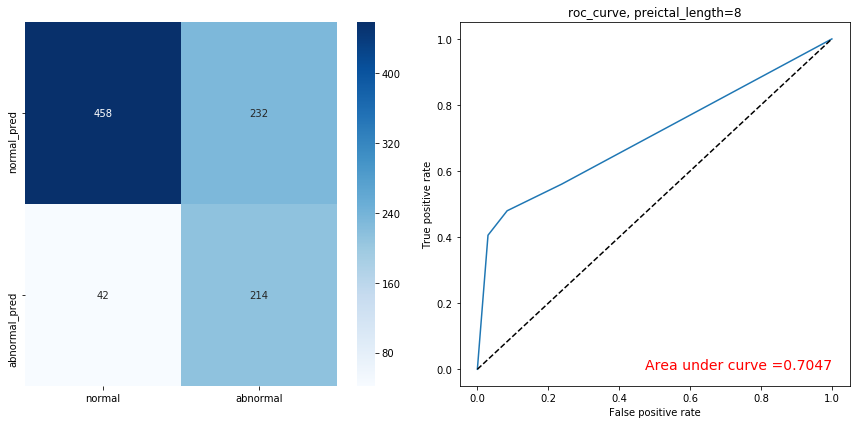

In [0]:
# combine ictal and preictal, label==1
train_y = np.where(train_y==2, 1, train_y)
test_y = np.where(test_y==2, 1, test_y)


neighbors=[3,5,7,9]
params = {"n_neighbors": neighbors, "weights":["uniform", "distance"]}
knc_clf2 = GridSearchCV(KNC(), param_grid=params, cv=10, verbose=1, n_jobs=8)

knc_clf2.fit(train_X, train_y)

print(f"Cross validation picked {knc_clf2.best_params_} as the best combination")
print(f"Mean accuracy from which is {knc_clf2.best_score_:.3f}")


prediction = knc_clf2.predict(test_X)
pred_prob = knc_clf2.predict_proba(test_X)[:, 1]
fpr, tpr, thresholds = roc_curve(test_y, pred_prob)

confusion = confusion_matrix(test_y, prediction)
report = classification_report(test_y, prediction, labels=[0,1], target_names=["normal", "abnormal"])

print(report)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

sns.heatmap(
    confusion.T, 
    cmap="Blues", 
    annot=True, 
    fmt="d", 
    xticklabels=["normal", "abnormal"], 
    yticklabels=["normal_pred", "abnormal_pred"],
    ax=ax1
)

ax2.plot(fpr, tpr)
ax2.plot((0,1), (0,1), linestyle="--", color="k")
ax2.set(xlabel="False positive rate", ylabel="True positive rate", title=f"roc_curve, preictal_length={preictal_length}")
ax2.text(1, 0, f"Area under curve ={auc(fpr, tpr):.4f}", size=14, ha="right", color="r")

fig.tight_layout()

In [0]:
pred_prob[:10]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.66666667])

# SVC 2-classes

In [0]:
# combine ictal and preictal, label==1
train_y = np.where(train_y==2, 1, train_y)
test_y = np.where(test_y==2, 1, test_y)

C_grid=[1, 3, 10]
gamma_grid=[0.01, 0.03, 0.1, 0.3]
params = {"C": C_grid, "gamma":gamma_grid}

svc_clf2 = GridSearchCV(
    SVC(class_weight="balanced", cache_size=2000),
    param_grid=params, 
    cv=10, 
    verbose=1, 
    n_jobs=8
)

svc_clf2.fit(train_X, train_y)

print(f"Cross validation picked {svc_clf2.best_params_} as the best combination")
print(f"Mean accuracy from which is {svc_clf2.best_score_:.3f}")

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   22.1s
[Parallel(n_jobs=8)]: Done 120 out of 120 | elapsed:  1.3min finished


Cross validation picked {'C': 10, 'gamma': 0.01} as the best combination
Mean accuracy from which is 0.908


              precision    recall  f1-score   support

      normal       0.67      0.91      0.77       500
    abnormal       0.82      0.49      0.62       446

    accuracy                           0.71       946
   macro avg       0.75      0.70      0.69       946
weighted avg       0.74      0.71      0.70       946



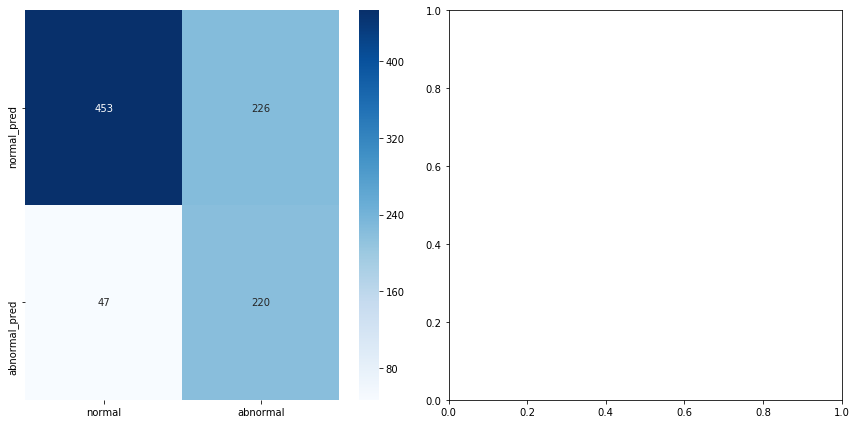

In [0]:
prediction = svc_clf2.predict(test_X)
# pred_prob = svc_clf2.predict_proba(test_X)[:, 1]
# fpr, tpr, thresholds = roc_curve(test_y, pred_prob)

confusion = confusion_matrix(test_y, prediction)
report = classification_report(test_y, prediction, labels=[0,1], target_names=["normal", "abnormal"])

print(report)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

sns.heatmap(
    confusion.T, 
    cmap="Blues", 
    annot=True, 
    fmt="d", 
    xticklabels=["normal", "abnormal"], 
    yticklabels=["normal_pred", "abnormal_pred"],
    ax=ax1
)

# ax2.plot(fpr, tpr)
# ax2.plot((0,1), (0,1), linestyle="--", color="k")
# ax2.set(xlabel="False positive rate", ylabel="True positive rate", title=f"roc_curve, preictal_length={preictal_length}")
# ax2.text(1, 0, f"Area under curve ={auc(fpr, tpr):.4f}", size=14, ha="right", color="r")

fig.tight_layout()

# Seq_test

past_seg=60
seg_per_preictal = int(preictal_length/4)
ictal_seg=4
total_seg = past_seg+seg_per_preictal+ictal_seg

starts = np.where(labels==1)[0][::seg_per_preictal]

prob = np.zeros(shape=(len(starts), total_seg, 2))
for i, start in enumerate(starts):
    data_idx = np.arange(start-past_seg, start+seg_per_preictal+ictal_seg, 1)
    data = scaler.transform(powers[data_idx])
    seq_prob = knc_clf_bi.predict_proba(data)
    prob[i, :, :] = seq_prob
    
mean = prob.mean(axis=0)
std =  prob.std(axis=0)

plt.figure(figsize=(12,8))
for i, l in zip(range(1,2,1), ["interictal", "preictal", "ictal"]):
    plt.errorbar(x=np.arange(total_seg), y=mean[:, i], yerr=std[:, i], label=l)

plt.ylim(-0.25, 1.25)
plt.ylabel("Prob")
plt.xticks(ticks=[past_seg, past_seg+seg_per_preictal], labels=["preictal", "ictal"])
plt.vlines(x=past_seg-0.1, ymin=-0.5, ymax=2.5, linestyle="--", color="C1")
plt.vlines(x=past_seg+seg_per_preictal-0.1, ymin=-0.5, ymax=2.5, linestyle="--", color="r")
plt.hlines(xmin=0, xmax=total_seg, y=0.5, linestyle="--", color="k")
plt.legend(loc="upper left")
plt.title(f"preictal length={preictal_length}")
# plt.savefig(f"KNN_preictal_{preictal_length}.png", dpi=150)
plt.show()



# mean = prob.argmax(-1).mean(axis=0)
# std =  prob.argmax(-1).std(axis=0)
# plt.errorbar(x=np.arange(total_seg), y=mean, yerr=std)    
# plt.ylim(-0.5, 2.5)
# plt.yticks(ticks=np.arange(0,3,1))
# plt.xticks(ticks=[past_seg, past_seg+seg_per_preictal], labels=["preictal", "ictal"])
# plt.vlines(x=past_seg-0.1, ymin=-0.5, ymax=2.5, linestyle="--", color="C1")
# plt.vlines(x=past_seg+seg_per_preictal-0.1, ymin=-0.5, ymax=2.5, linestyle="--", color="r")
# plt.show()

  

np.random.seed(13)
t2 = scaler.transform(powers[np.where(labels==0)])
d2 = t2[np.random.rand(t2.shape[0]) > 0.99]
p = knc_clf_tri.predict_proba(d2)
mean = p.mean(axis=0)
std = p.std(axis=0)


(p.argmax(-1)==0).sum(), (p.argmax(-1)==1).sum(), (p.argmax(-1)==2).sum()